**Clustering Text**

In [2]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string
from bs4 import BeautifulSoup
import re
from gensim.models.coherencemodel  import CoherenceModel
import time
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
import spacy
import pandas as pd
# warnings imports
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans

nlp = spacy.load("en_core_web_sm")

In [3]:
news_data = pd.read_csv('news.csv' , delimiter=',' , encoding='latin-1' )
news_data = news_data[['text']]
news_data['label'] = 0
news_data= news_data[:12000]
news_data.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,0
1,WASHINGTON (Reuters) - Transgender people will...,0
2,WASHINGTON (Reuters) - The special counsel inv...,0
3,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,0


In [276]:
crypto_data = pd.read_csv('crypto_tweets.csv' , delimiter=',' , encoding='latin-1' )
crypto_data = crypto_data[['text']]
crypto_data['label'] = 1
# we get only the 10000 first rows
crypto_data = crypto_data[:1200]
crypto_data.head(20)

,text,label
0,The compensation process is expected to start ...,1
1,On-chain analytics revealed a sentiment shift ...,1
2,"Ether has broken the $1,900 resistance level f...",1
3,"With a new quarterly production record, Marath...",1
4,The stablecoin BTG Dol will supposedly become ...,1
5,As concerns about a regulatory crackdown in th...,1
6,Amid concerns of a potential recession due to ...,1
7,Marathon produced almost 40% of its Q1 bitcoin...,1
8,The token protocol can be used for a wide vari...,1
9,The launch of OpenSea Pro is the result of Ope...,1


In [277]:
data = pd.concat([news_data, crypto_data], ignore_index=True)
data[:]

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,0
1,WASHINGTON (Reuters) - Transgender people will...,0
2,WASHINGTON (Reuters) - The special counsel inv...,0
3,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,0
...,...,...
13195,The BIS has completed a pilot study of the use...,1
13196,Dogecoin has pulled back from earlier session ...,1
13197,The death of Silvergate's SEN could play a maj...,1
13198,Arbitrum is making moves to become the hub of ...,1


## Preprocessing and cleaning the data :

In [278]:
# drop rows with empty comments
data = data[data['text'].apply(lambda x: isinstance(x, str))]
# Remove URLs
data['text'] = data['text'].apply(lambda x: re.sub(r'http\S+', '', x))
# Remove digits
data['text'] = data['text'].apply(lambda x: re.sub(r'\d+', '', x))
# Remove HTML tags
data['text'] = data['text'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())
# Remove punctuation
data['text'] = data['text'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))

doc_list = []
doc_list = data['text']

 # Tokenization
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
data['text'] = data['text'].apply(lambda x: tokenizer.tokenize(x) if isinstance(x, str) else [])

# Remove punctuation and stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['...', '…'])
data['text'] = data['text'].apply(
    lambda tokens: [token.lower() for token in tokens if token not in stop_words and token not in string.punctuation]
)

# remove lines that contain less than 3 words or contain non-alphabetic characters
data = data[data['text'].apply(lambda x: len(x) >= 3 and all([type(token) == str and token.isalpha() for token in x]))]

# drop duplicates and empty comments
data.drop_duplicates(subset=['text'], inplace=True)
data['text'] = data['text'].apply(tuple)
data.drop_duplicates(subset=['text'], inplace=True)


data.dropna(subset=['text'], inplace=True)
#reset index
data = data.reset_index(drop=True)
data.head()
# print(len(data))

C:\Users\rachi\AppData\Local\Temp\ipykernel_16656\2352793919.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  data['text'] = data['text'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())


,text,label
0,"(following, statementsâ, posted, verified, twi...",0
1,"(washington, reuters, legislation, provide, bi...",0
2,"(washington, reuters, us, house, representativ...",0
3,"(washington, reuters, us, house, representativ...",0
4,"(following, statementsâ, posted, verified, twi...",0


In [279]:
# print the length of the data where label = 0 and label = 1
print(len(data[data['label'] == 0]))
print(len(data[data['label'] == 1]))
print(len(data))

1068
1006
2074


In [280]:
# print the number of documents in doc_list
print('Number of documents: ', len(doc_list))

Number of documents:  13200


# Transforming data into TFID format 

In [281]:
documents = data['text'].apply(lambda x: ' '.join(x))

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english', use_idf=True)

# Fit and transform the documents
X = vectorizer.fit_transform(documents) #X is a sparse matrix that contains the tf-idf vectors for each document
# displayin some of the tf-idf vectors
print(X.shape)
print(X[0])

(2074, 4496)
  (0, 449)	0.12781605973045487
  (0, 448)	0.12781605973045487
  (0, 2310)	0.12144229236293924
  (0, 3741)	0.10023758090486412
  (0, 2948)	0.15899270364847465
  (0, 2388)	0.10716831964127142
  (0, 1104)	0.13289043310537615
  (0, 2320)	0.11758095464636541
  (0, 4470)	0.06847372047495069
  (0, 1234)	0.12971781927952175
  (0, 438)	0.13935139070120758
  (0, 2352)	0.13935139070120758
  (0, 2696)	0.17915384910840007
  (0, 2968)	0.23172533117708669
  (0, 3824)	0.0714324776764871
  (0, 4221)	0.06923775127674225
  (0, 1399)	0.29650769745683797
  (0, 3494)	0.09208021776567053
  (0, 959)	0.13178514960700635
  (0, 2611)	0.1505183528891907
  (0, 2429)	0.1244160823460922
  (0, 1148)	0.09911928929746293
  (0, 2672)	0.10497359324152658
  (0, 244)	0.15899270364847465
  (0, 1052)	0.1955832162653222
  :	:
  (0, 3193)	0.29237303680186877
  (0, 240)	0.1221515781853205
  (0, 2359)	0.1352683470783852
  (0, 3720)	0.12971781927952175
  (0, 3978)	0.13072900637548637
  (0, 2629)	0.07664920804141143
 

# K MEANS 

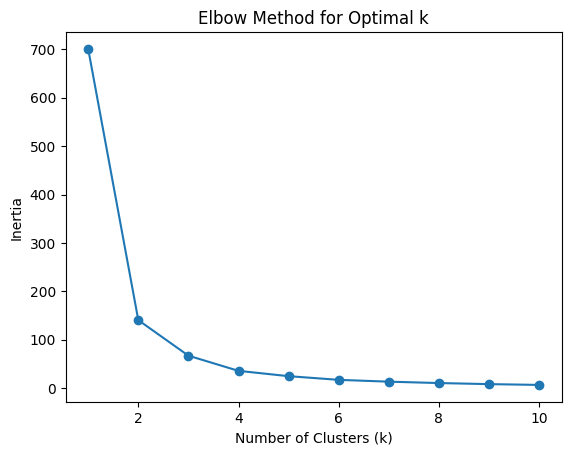

In [282]:
warnings.filterwarnings("ignore", category=FutureWarning)
def find_optimal_k(documents, max_k=10):
    vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True)
    X = vectorizer.fit_transform(documents)

    svd = TruncatedSVD(n_components=2)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X = lsa.fit_transform(X)

    inertias = []

    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.plot(range(1, max_k + 1), inertias, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia') # Inertia: Sum of squared distances of samples to their closest centroid
    plt.title('Elbow Method for Optimal k')
    plt.show()

documents = data['text'].apply(lambda x: ' '.join(x))

# Call the function to find the optimal k
find_optimal_k(documents, max_k=10)

In [283]:
# Use TruncatedSVD for dimensionality reduction
n_components = 3
svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

# Fit and transform the TF-IDF matrix
X_transformed = lsa.fit_transform(X)

# Apply KMeans clustering
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X_transformed)

# Print top words for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
# for i in range(num_clusters):
#     print(f"Cluster {i}:")
#     for ind in order_centroids[i, :5]:
#         print(f' {terms[ind]}')

# Evaluate the clustering performance
print("Homogeneity: %0.3f" % metrics.homogeneity_score(data['label'], kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(data['label'], kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(data['label'], kmeans.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(data['label'], kmeans.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_transformed, data['label'], sample_size=2000))

Homogeneity: 0.654
Completeness: 0.670
V-measure: 0.662
Adjusted Rand-Index: 0.705
Silhouette Coefficient: 0.492


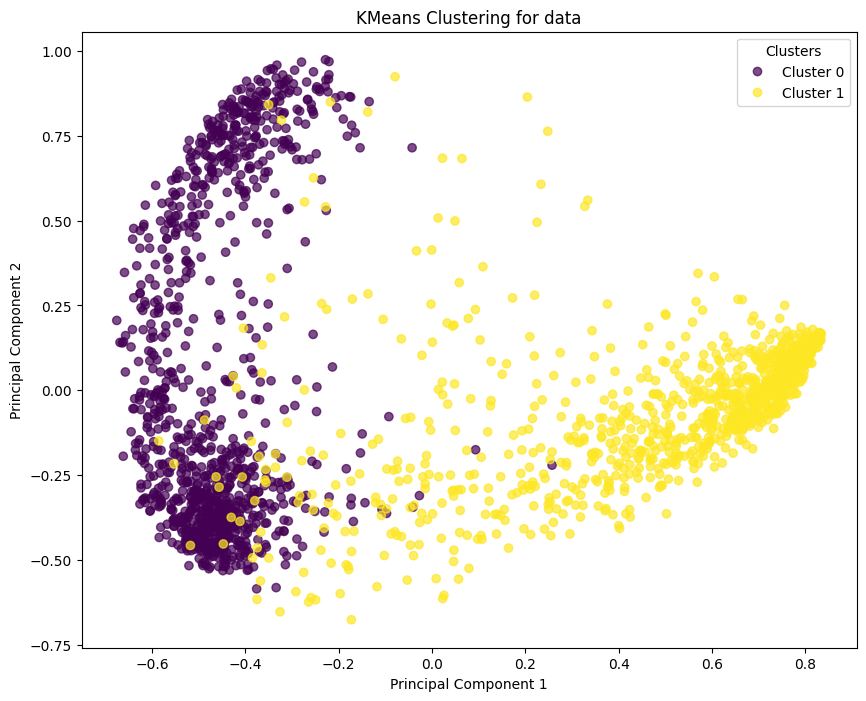

In [284]:
from sklearn.decomposition import PCA

# Assuming 'clean_comment' is the column containing your preprocessed text data
documents = data['text'].apply(lambda x: ' '.join(x))

# Fit and transform TF-IDF data using the previously trained vectorizer and SVD
X_transformed = lsa.fit_transform(vectorizer.transform(documents))
# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)

# Plot the clusters in 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['label'], cmap='viridis', alpha=0.7)
plt.title('KMeans Clustering for data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add legend
legend_labels = [f'Cluster {i}' for i in range(num_clusters)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters')

plt.show()

# Clustering using CLARANS (Clustering Large Applications based upon RANdomized Search)

In [285]:
documents = data['text'].apply(lambda x: ' '.join(x))
documents[:]

0       following statementsâ posted verified twitter ...
1       washington reuters legislation provide billion...
2       washington reuters us house representatives th...
3       washington reuters us house representatives th...
4       following statementsâ posted verified twitter ...
                              ...                        
2069    bis completed pilot study use cbdcs crossborde...
2070    dogecoin pulled back earlier session highs tha...
2071    death silvergates sen could play major role dr...
2072    arbitrum making moves become hub decentralized...
2073    crypto market experienced minimal activity lac...
Name: text, Length: 2074, dtype: object

In [291]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.clarans import clarans

# Vectorize and transform the data using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True)
X = vectorizer.fit_transform(documents[:1500])

# Apply TruncatedSVD for dimensionality reduction
n_components = 3
svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_transformed = lsa.fit_transform(X)

# Set the number of clusters
num_clusters = 2

# Set the number of neighbors to be examined
num_neighbors = 3

# Set the maximum number of neighbors to be examined
max_neighbors = 5  

# Convert the data to a list of lists
data_list = X_transformed.tolist()

# CLARANS algorithm
clarans_instance = clarans(data_list, num_clusters, num_neighbors, max_neighbors)
clarans_instance.process()

# Get the results (clusters and medoids)
clusters = clarans_instance.get_clusters()
medoids = clarans_instance.get_medoids()

# Print medoids
print("CLARANS Medoids:")
for medoid in medoids:
    print(data_list[medoid])

CLARANS Medoids:
[0.9462294738413507, -0.27114048817273767, -0.1764443779420871]
[0.7665133720683247, 0.6399531642469268, -0.05401109155342042]


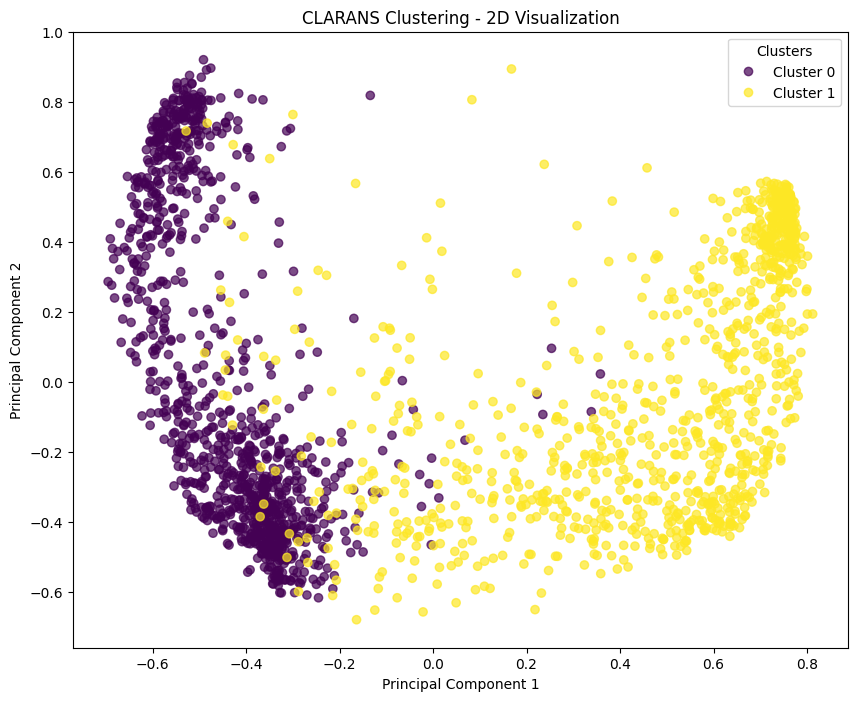

In [293]:
# Assuming 'clean_comment' is the column containing your preprocessed text data
documents = data['text'].apply(lambda x: ' '.join(x))

# Fit and transform TF-IDF data using the previously trained vectorizer and SVD
X_transformed = lsa.fit_transform(vectorizer.transform(documents))

# use PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)

# Plot the clusters in 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['label'], cmap='viridis', alpha=0.7)
plt.title('CLARANS Clustering - 2D Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add legend
legend_labels = [f'Cluster {i}' for i in range(num_clusters)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters')

plt.show()

**Some comparaison Between clustering Algorithm**

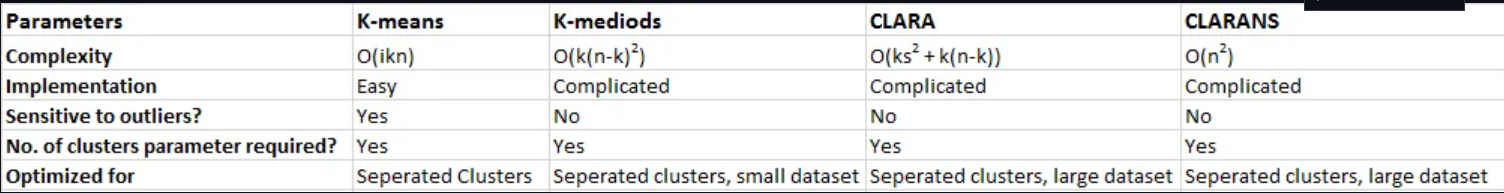